In [32]:
import torch
import torch.nn.functional as F
from models import Create_nets
from datasets import get_dataloader
#from options import TrainOptions
from torchvision import models
import os
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import cv2
from utils.results import *
from matplotlib.cm import viridis
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from utils.dataloader import get_paths_mvtec
from datasets import ImageDataset_mvtec
from torch.utils.data import DataLoader
import copy

In [2]:
import os
import json

class TrainOptions:
    def __init__(self):
        self.exp_name = "DEV_USDR"
        self.epoch_start = 0
        self.epoch_num = 1
        self.factor = 1
        self.seed = 233
        self.fixed_seed_bool = True
        self.test_seed = 400
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.data_category = "screw"
        self.data_set = "mvtec"
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.results_dir = 'results'
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.contamination_rate = 0.1
        self.assumed_contamination_rate = 0.1
        self.mode = 'mvtec'
        self.development = False
        self.parser = None
        self.initialized = False


In [3]:
args = TrainOptions()
os.makedirs(args.results_dir, exist_ok=True)
os.makedirs(os.path.join(args.results_dir, args.data_set, f'contamination_{int(args.contamination_rate*100)}', f'{args.exp_name}-{args.data_category}', args.image_result_dir), exist_ok=True)
os.makedirs(os.path.join(args.results_dir, args.data_set, f'contamination_{int(args.contamination_rate*100)}', f'{args.exp_name}-{args.data_category}', args.model_result_dir), exist_ok=True)

try:
    with open(os.path.join('configurations', f'{args.data_set}.json'), 'r') as file:
        dataset_parameters = json.load(file)
    setattr(args, 'dataset_parameters', dataset_parameters)
except FileNotFoundError:
    print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
    setattr(args, 'dataset_parameters', {})
    
torch.manual_seed(args.seed)

## USDR

In [5]:
anomaly_categories={
    "bottle": ["broken_large", "broken_small", "contamination"],
    "cable": ["bent_wire", "cable_swap", "combined", "cut_inner_insulation", "cut_outer_insulation", "missing_cable", "missing_wire", "poke_insulation"],
    "capsule": ["crack", "faulty_imprint", "poke", "scratch","squeeze"],
    "carpet": ["color", "cut", "hole", "metal_contamination", "thread"],
    "grid": ["bent", "broken", "glue", "metal_contamination", "thread"],
    "hazelnut": ["crack", "cut", "hole", "print"],
    "leather": ["color", "cut", "fold", "glue", "poke"],
    "metal_nut": ["bent", "color", "flip", "scratch"],
    "pill": ["color", "combined","contamination", "crack", "faulty_imprint", "pill_type","scratch"],
    "screw": ["manipulated_front", "scratch_head", "scratch_neck","thread_side", "thread_top"],
    "tile": ["crack", "glue_strip", "gray_stroke", "oil","rough"],
    "toothbrush": ["defective"],
    "transistor": ["bent_lead", "cut_lead", "damaged_case", "misplaced"],
    "wood": ["color", "combined", "hole", "liquid", "scratch"],
    "zipper": ["broken_teeth", "combined","fabric_border", "fabric_interior","split_teeth","rough", "squeezed_teeth"]
    }
category='screw'
anocat=anomaly_categories[category]

In [6]:
normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_mvtec(args,verbose=True)
DATA_PATH=os.path.join(args.data_root,args.data_category)
# combine good and anomalies
train_data=normal_images+sampled_anomalies_for_train
labels_train=[0]*len(normal_images)+[1]*len(sampled_anomalies_for_train)

category: screw, normals train:  320, anomalies test: 119, normal test: 41
anomalies test total:     {'manipulated_front': 24, 'scratch_head': 24, 'scratch_neck': 25, 'thread_side': 23, 'thread_top': 23}
anomalies test sampled:   {'manipulated_front': 6, 'scratch_head': 6, 'scratch_neck': 6, 'thread_side': 6, 'thread_top': 6}
anomalies test remaining: {'manipulated_front': 18, 'scratch_head': 18, 'scratch_neck': 19, 'thread_side': 17, 'thread_top': 17}


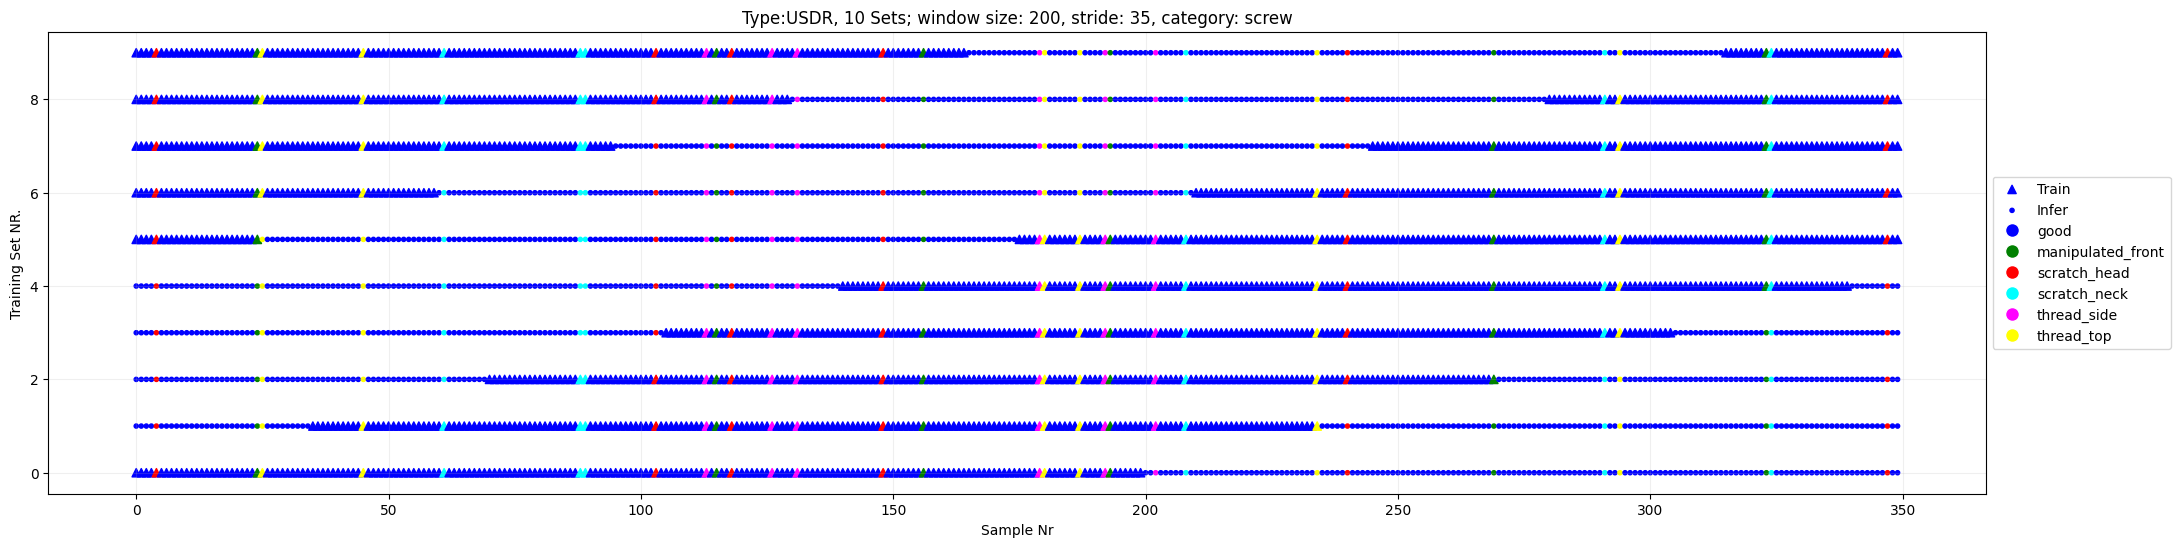

In [7]:
np.random.seed(args.seed)
N_samples = len(train_data)
idx = np.arange(N_samples)
np.random.shuffle(idx)

all_data_paths=[train_data[id]for id in idx]
ano_cols = [ 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white']
colorvec=['blue']*len(train_data)#all cols to blue base is normal

anocat=args.dataset_parameters['anomaly_categories'][args.data_category]

for i,cat in enumerate(anocat):
    for id_, (col,path) in enumerate(zip(colorvec,all_data_paths)):
        if cat in path:
            colorvec[id_]=ano_cols[i]


# VISUALIZATION WITH 2 HISTOGRAMS PER SPLIT (TRAIN, TEST) NORMAL/ABNORMAL IN SPLIT OUT OF SPLIT
##USDR
stride = 35
window_size = 200
# Create train sets
shifts = np.floor(N_samples / stride)
train_sets = int(shifts)

train_ind_ls = []
for i in range(train_sets):
    train_ind_ls.append(idx[np.arange(i * stride, i * stride + window_size) % N_samples])
#save split plot  
plot_splits(train_ind_ls, idx, all_data_paths, train_sets, anocat, args.data_category, stride, window_size,splittype='USDR',EXPERIMENT_PATH=None)

In [17]:
import pickle

file_path = "/home/bule/projects/UTRAD/results/mvtec/contamination_10/USDR_19_05_24_5set-screw/allpaths.pkl"
with open(file_path, "rb") as file:
    data = pickle.load(file)
    
file_path = "/home/bule/projects/UTRAD/results/mvtec/contamination_10/USDR_19_05_24_5set-screw/allscores.pkl"
with open(file_path, "rb") as file:
    scores = pickle.load(file)
    
    
df = pd.read_pickle('/home/bule/projects/UTRAD/results/mvtec/contamination_10/USDR_19_05_24_5set-screw/USDR_window:200_stride:70.pkl')
df

,indicator,idx,scores_test_mean,scores_test_std,scores_train_mean,scores_train_std
0,0.391098,161,-0.338515,0.210146,0.052584,0.587991
1,0.444337,40,-0.429287,0.179583,0.015051,0.841266
2,0.013307,195,-0.586089,0.332222,-0.572782,0.327877
3,0.735069,309,0.733089,0.699031,-0.001980,0.708520
4,1.208274,339,0.591744,0.228280,1.800018,0.890479
...,...,...,...,...,...,...
345,0.077268,193,1.682701,0.354451,1.605433,0.647271
346,1.114102,175,0.667669,1.217451,-0.446433,0.680514
347,2.491855,341,0.528876,0.106969,3.020731,1.189744
348,0.221800,131,-0.663447,0.458543,-0.441646,0.408358


In [15]:
import json

file_path = '/home/bule/projects/UTRAD/results/mvtec/contamination_10/USDR_18_05_24-5set-screw/experiment_paths.json'

with open(file_path, 'r') as file:
    data = json.load(file)

print(data[''])


FileNotFoundError: [Errno 2] No such file or directory: '/home/bule/projects/UTRAD/results/mvtec/contamination_10/USDR_18_05_24-5set-screw/experiment_paths.json'

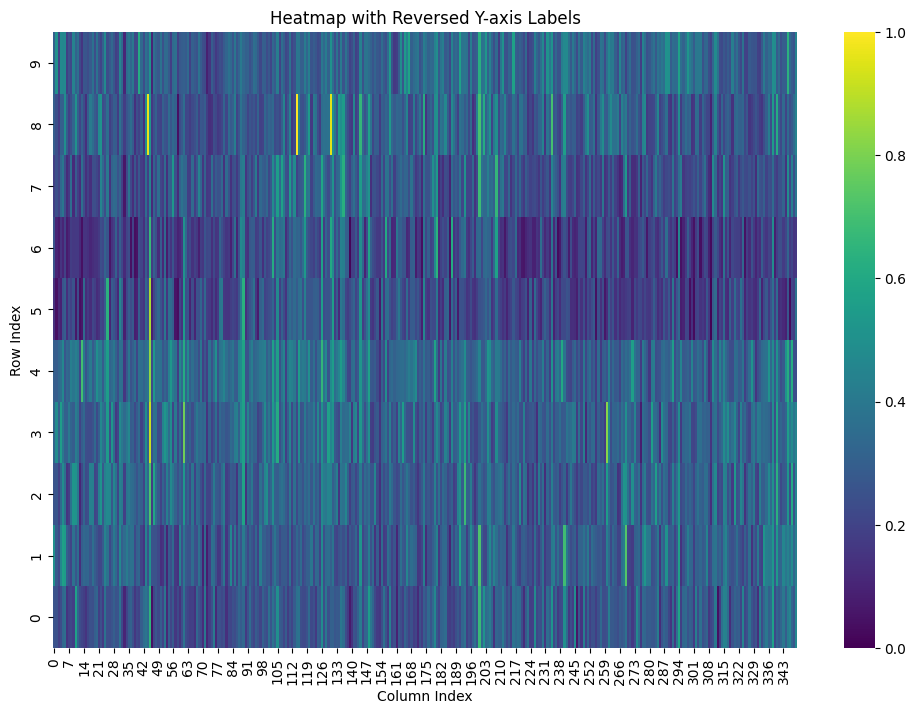

In [16]:
# min max scaling
scaled= (scores -scores.min())/ (scores.max()-scores.min())
# Create a heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(scaled[::-1], cmap='viridis')

# Reverse the y-axis labels
ax.set_yticklabels(ax.get_yticklabels()[::-1])

plt.title('Heatmap with Reversed Y-axis Labels')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

In [17]:
np.random.seed(args.seed)
N_samples = len(train_data)
idx = np.arange(N_samples)
np.random.shuffle(idx)


stride = 35
window_size = 200
# Create train sets
shifts = np.floor(N_samples / stride)
train_sets = int(shifts)

train_ind_ls = []
for i in range(train_sets):
    train_ind_ls.append(idx[np.arange(i * stride, i * stride + window_size) % N_samples])

In [18]:
sorted_scores=[]
scaled_scores = (scores - scores.min()) / (scores.max() - scores.min())
for j in range(train_sets):
    sorted_part = [scaled_scores[j,i] for i in train_ind_ls[j]]
    remaining_part = [scaled_scores[j,i] for i in range(len(scaled_scores[j,:])) if i not in train_ind_ls[j]]
    sorted_scores.append(sorted_part + remaining_part)
    print(len(sorted_part),len(remaining_part),len(sorted_scores[j]))
sorted_scores = np.array(sorted_scores)

200 150 350
200 150 350
200 150 350
200 150 350
200 150 350
200 150 350
200 150 350
200 150 350
200 150 350
200 150 350


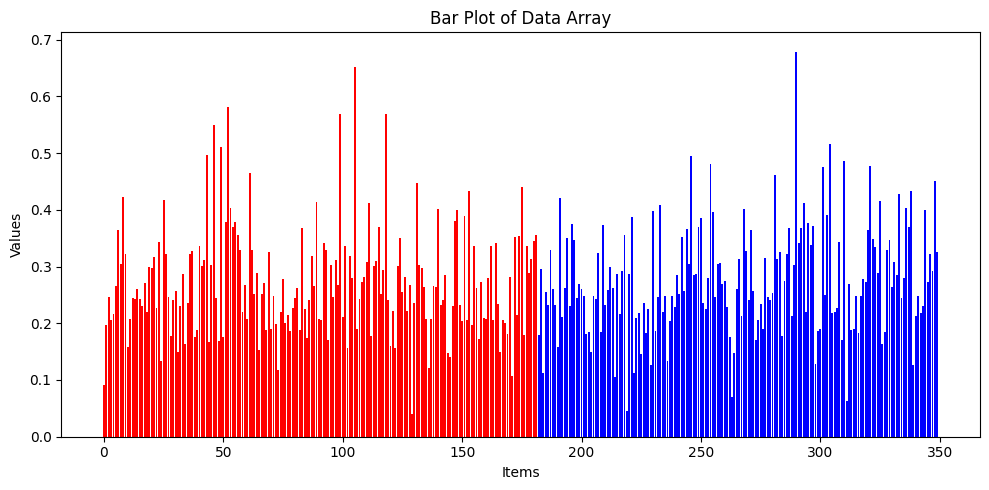

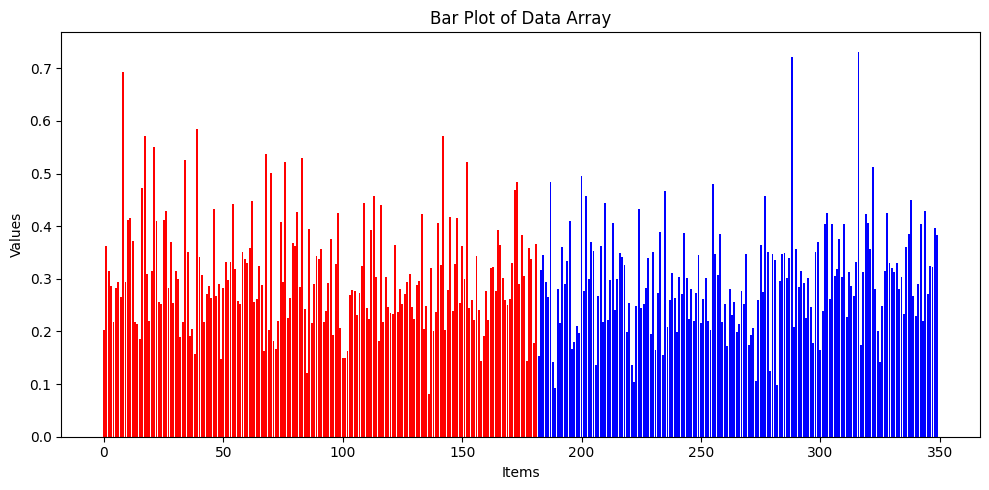

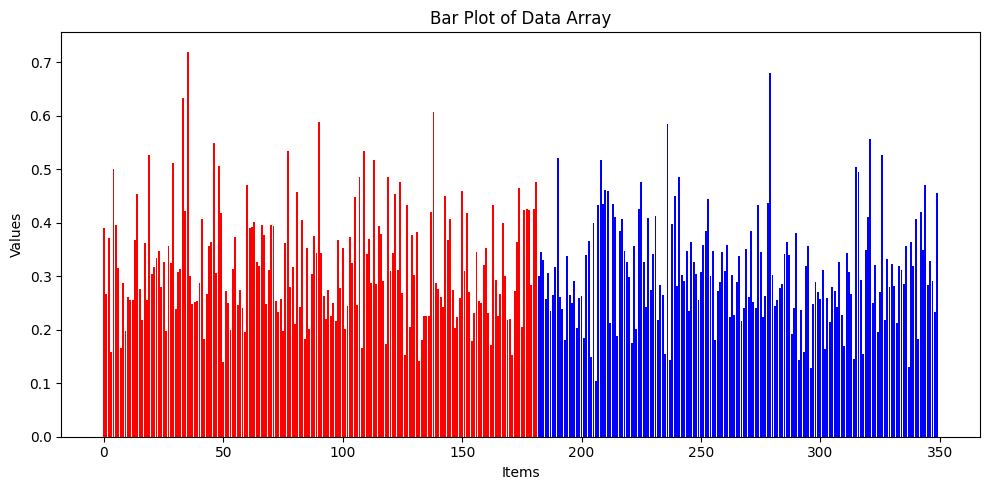

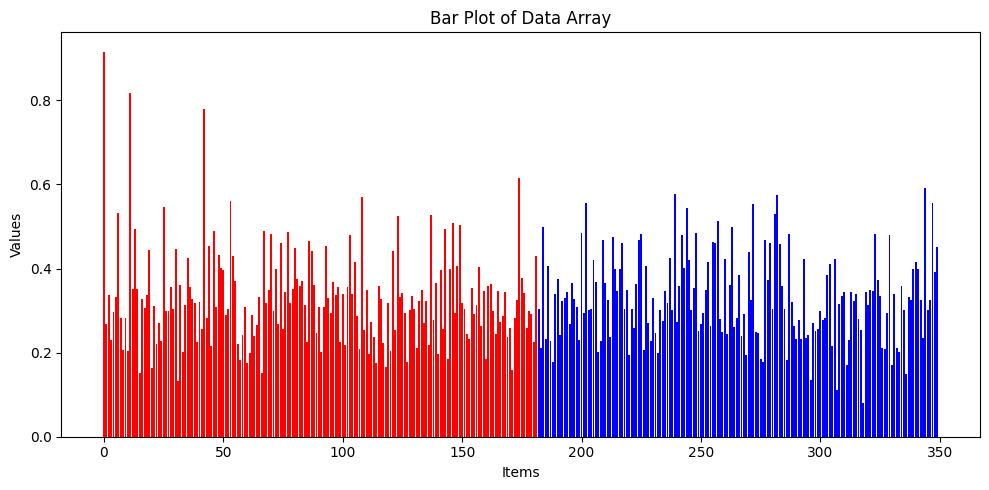

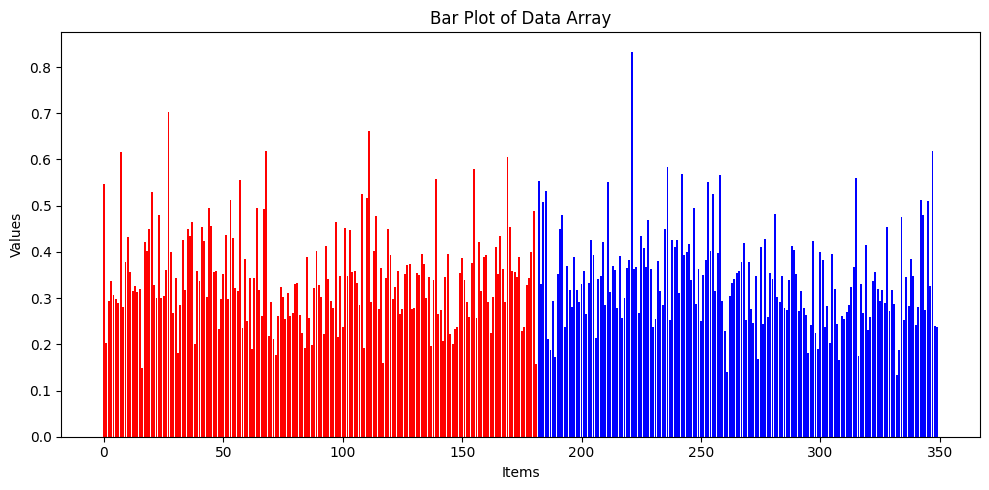

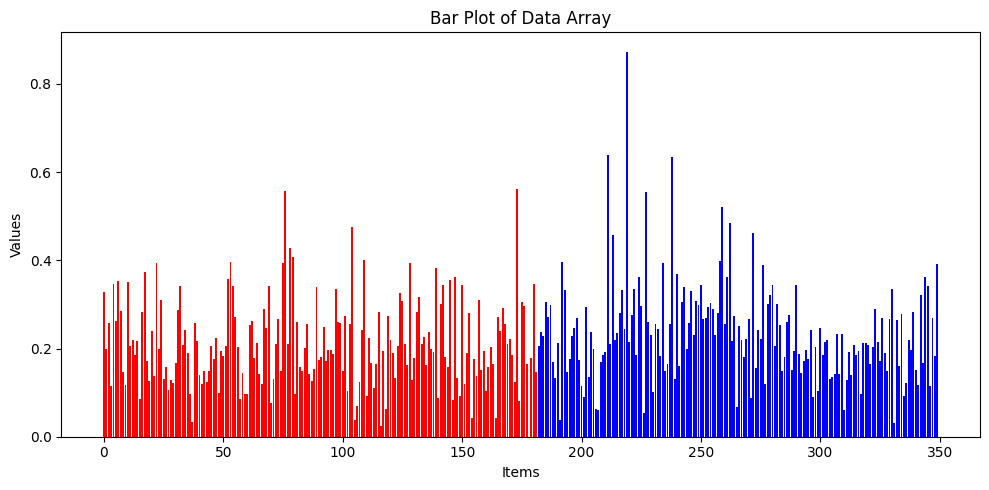

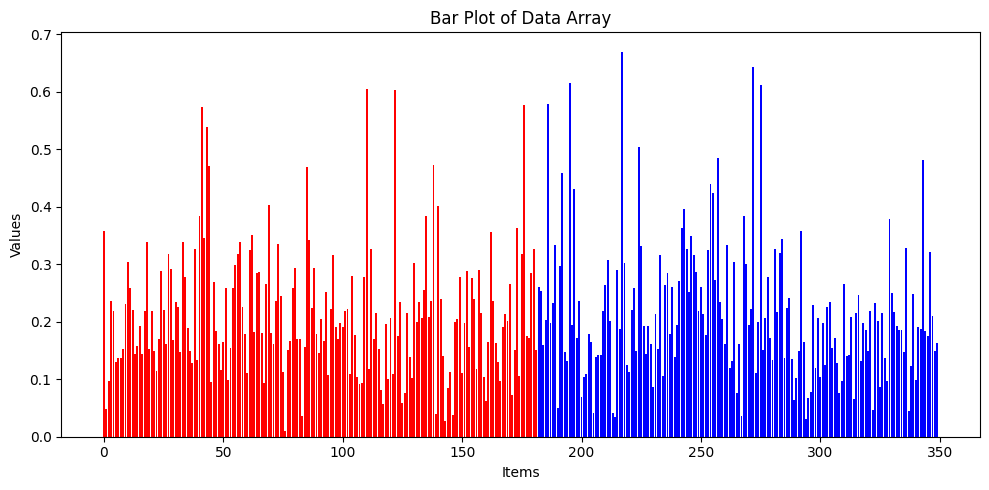

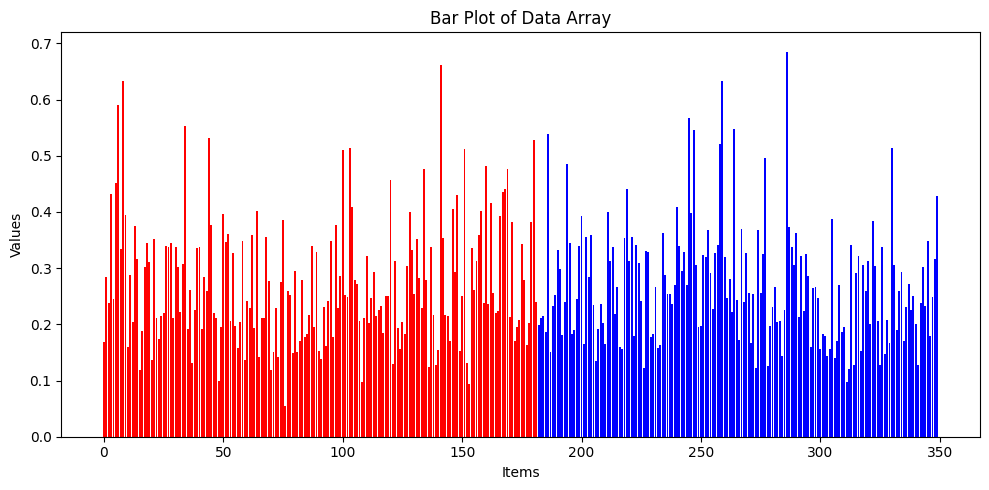

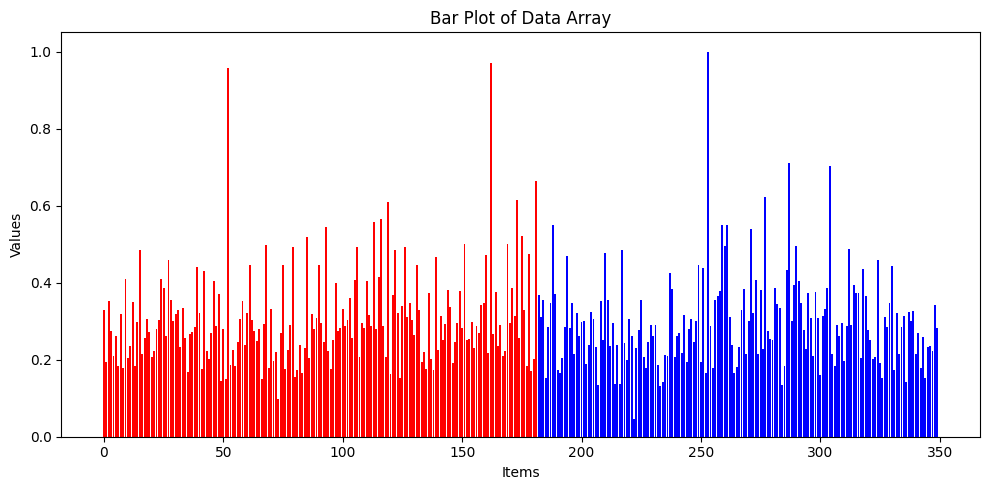

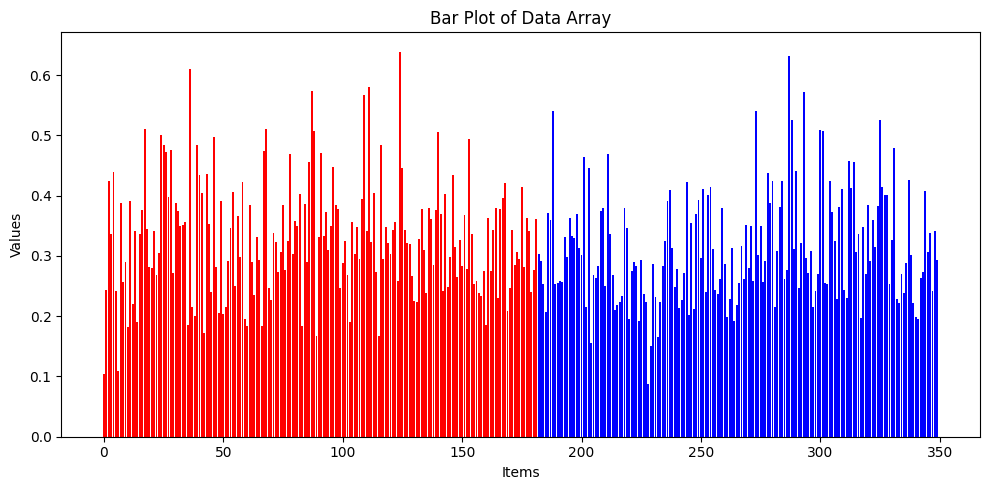

In [19]:

# Plotting the bar plot
# Plotting the bar plot
for i in range(sorted_scores.shape[0]):
    plt.figure(figsize=(10, 5))
    colors = ['red' if x < 182 else 'blue' for x in range(len(scaled[i]))]  # Color first 182 bars in red
    plt.bar(range(len(sorted_scores[i])), sorted_scores[i], color=colors)
    plt.xlabel('Items')
    plt.ylabel('Values')
    plt.title('Bar Plot of Data Array')
    #plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

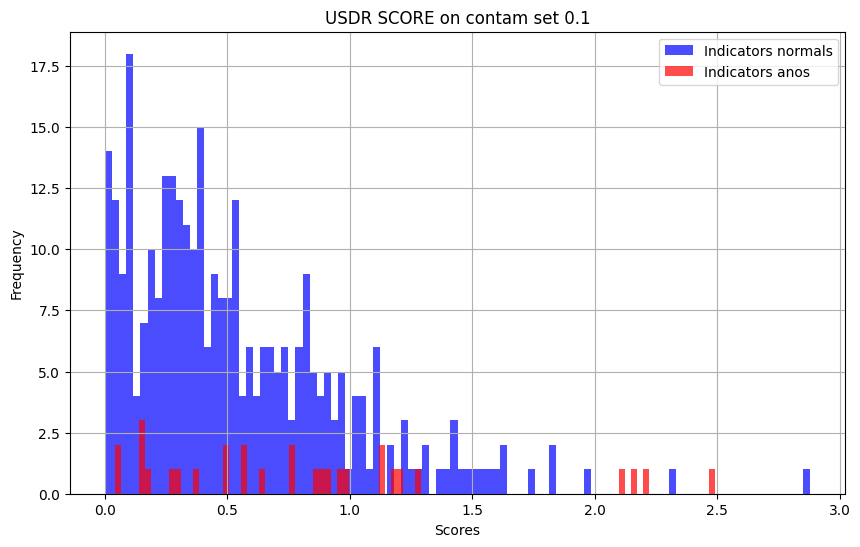

In [18]:
indicator=df['indicator']
idx=df['idx']
indicator=np.array(indicator)

idx_labs=[labels_train[idx] for idx in idx]
#indicator = np.abs(scores_test_mean - scores_train_mean)

score_0 = indicator[np.where(np.array(idx_labs) == 0)]
score_1 = indicator[np.where(np.array(idx_labs) == 1)]


plt.figure(figsize=(10, 6))
plt.hist(score_0, color='blue', bins=100, alpha=0.7, label='Indicators normals')
plt.hist(score_1, color='red', bins=100, alpha=0.7, label='Indicators anos')
plt.xlabel('Scores')
plt.ylabel('Frequency')

plt.title(f'USDR SCORE on contam set {args.contamination_rate}')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   indicator          350 non-null    float32
 1   idx                350 non-null    int64  
 2   scores_test_mean   350 non-null    float32
 3   scores_test_std    350 non-null    float32
 4   scores_train_mean  350 non-null    float32
 5   scores_train_std   350 non-null    float32
dtypes: float32(5), int64(1)
memory usage: 9.7 KB


In [ ]:
indicator=df['indicator']
idx=df['idx']

In [ ]:
path=os.path.join(EXPERIMENT_PATH,f'USDR_window:{window_size}_stride:{stride}.pkl')
resdict={'indicator':indicator,'idx':idx}
pd.DataFrame(resdict).to_pickle(os.path.join(EXPERIMENT_PATH,f'USDR_window:{window_size}_stride:{stride}.pkl'))

In [10]:

idx_labs=[labels_train[idx] for idx in idx]
indicator = np.abs(scores_test_mean - scores_train_mean)

score_0 = indicator[np.where(np.array(idx_labs) == 0)]
score_1 = indicator[np.where(np.array(idx_labs) == 1)]


plt.figure(figsize=(10, 6))
plt.hist(score_0, color='blue', bins=100, alpha=0.7, label='Indicators normals')
plt.hist(score_1, color='red', bins=100, alpha=0.7, label='Indicators anos')
plt.xlabel('Scores')
plt.ylabel('Frequency')

plt.title(f'USDR SCORE on contam set {args.contamination_rate}')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'idx' is not defined

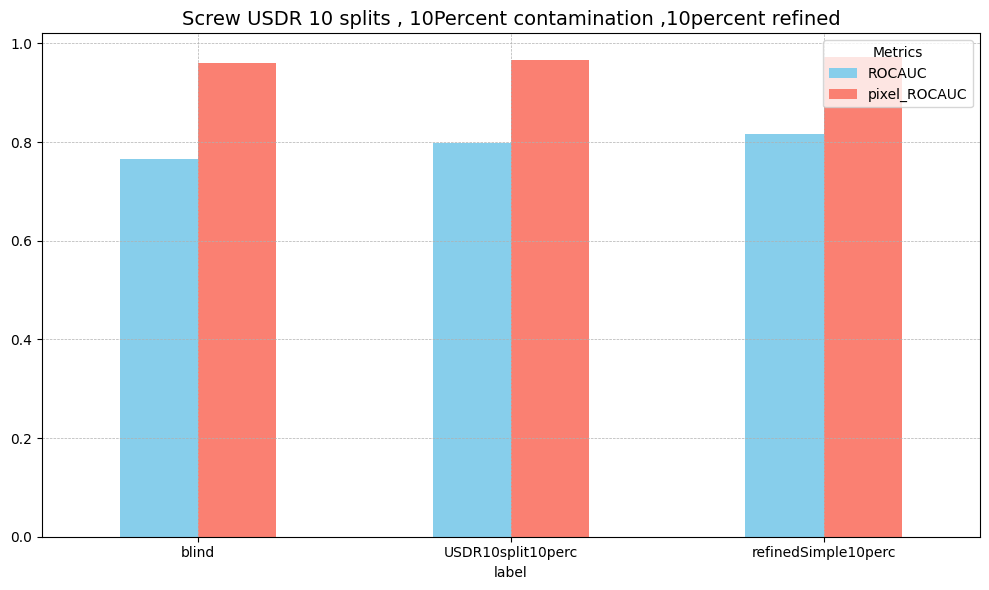

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
df = pd.DataFrame({'ROCAUC': [0.765, 0.799, 0.816], 'pixel_ROCAUC': [0.961, 0.966, 0.972],'label':['blind','USDR10split10perc','refinedSimple10perc']})

# Plotting
ax = df.plot(x='label', y=['ROCAUC', 'pixel_ROCAUC'], kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])

# Adding grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding titles and labels
ax.set_title('Screw USDR 10 splits , 10Percent contamination ,10percent refined', fontsize=14)
ax.legend(title='Metrics')

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [59]:
import pickle

file_path = "/home/bule/projects/UTRAD/results/mvtec/contamination_0/DEV_FewData_21_05_24-screw/all_trainscores.pkl"
with open(file_path, "rb") as file:
    data = pickle.load(file)
    
    
import json

file_path = '/home/bule/projects/UTRAD/results/mvtec/contamination_0/DEV_FewData_21_05_24-screw/experiment_paths.json'

with open(file_path, 'r') as file:
    exppath = json.load(file)
    


0.0005569731912657104 0.0005956058837436483


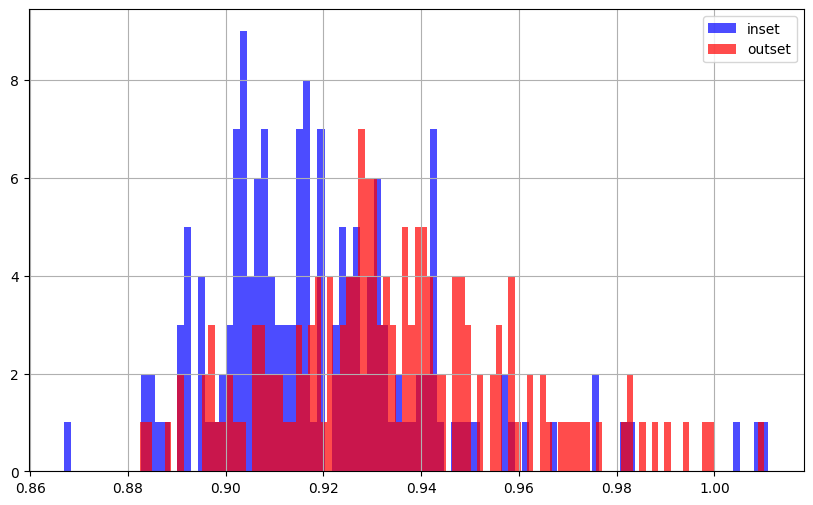

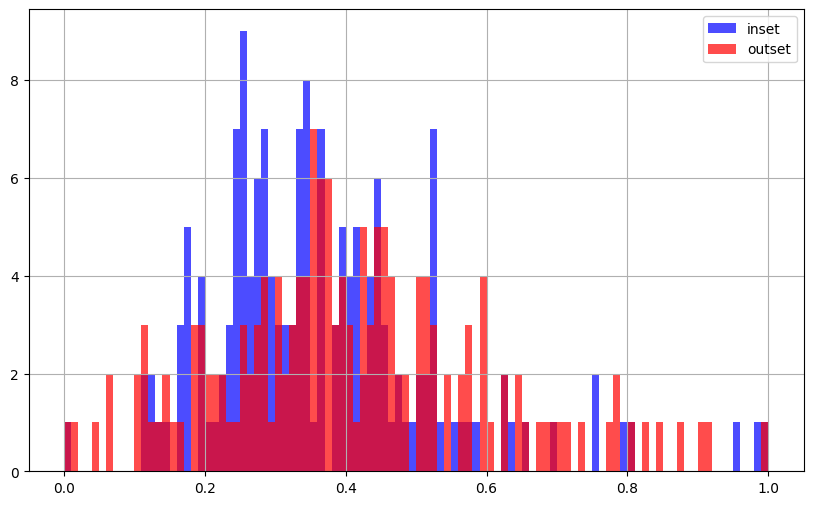

In [60]:

score_0 = np.array(data.tolist()[:160])


score_0_S= (score_0 - min(score_0)) / (max(score_0) - min(score_0))

score_1 = np.array(data.tolist()[160:])
score_1_S= (score_1 - min(score_1)) / (max(score_1) - min(score_1))



print(np.var(score_0),np.var(score_1))


plt.figure(figsize=(10, 6))
plt.hist(score_0, color='blue', bins=100, alpha=0.7, label='inset')
plt.hist(score_1, color='red', bins=100, alpha=0.7, label='outset')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(score_0_S, color='blue', bins=100, alpha=0.7, label='inset')
plt.hist(score_1_S, color='red', bins=100, alpha=0.7, label='outset')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
np.mean(score_0)


0.9753919135779142

In [51]:
np.mean(score_1)

0.9825922336429358

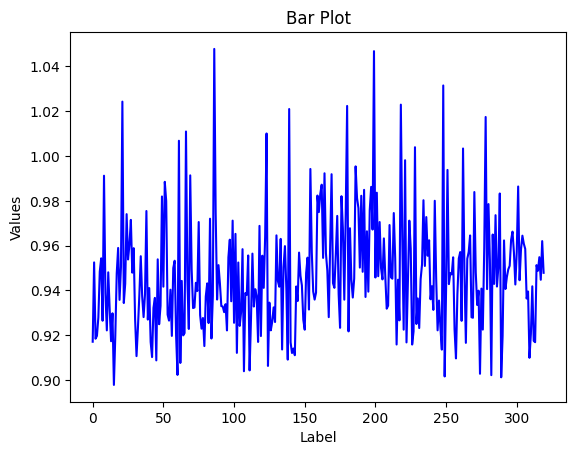

In [56]:
plt.plot(np.concatenate([score_0,score_1]),color='blue')
plt.xlabel('Label')
plt.ylabel('Values')
plt.title('Bar Plot')
plt.show()